In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nfl_data_py as nfl
import pandas as pd
import os
import numpy as np
import urllib.request

#displaying data imports
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg
import seaborn as sns


#basic ML imports
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [3]:
#clean 2024 data

df_twofour = nfl.import_pbp_data([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], downcast=True, cache=False, alt_path=None, include_participation=False)

#regular season data only
df_twofour = df_twofour.loc[df_twofour.season_type=='REG']

#remove kick offs, field goals, kneels, etc - only plays with passes, runs, and penalties
#df_twofour = df_twofour.loc[(df_twofour.play_type.isin(['no_play','pass','run'])) & (df_twofour.epa.isna()==False)]

#match play call to play type, so QB scrambles still considered pass plays
df_twofour.loc[df_twofour['pass']==1, 'play_type'] = 'pass'
df_twofour.loc[df_twofour.rush==1, 'play_type'] = 'run'

#reset index to skip missing numbers
df_twofour.reset_index(drop=True, inplace=True)

df_twofour.head()

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,None,None,None,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-0.497988,NaN,NaN,NaN,NaN,NaN,0.452352,-45.235191
3,72.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-0.378146,NaN,NaN,NaN,NaN,NaN,0.588882,-58.888157
4,93.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-1.542538,0.509138,5.985426,2.0,1.0,1.0,0.975684,2.431589


In [4]:
#get game scores. You only need max for total_home_score and total_away_score. You do not need to consider posteam and in fact this may return the wrong info because certain plays are excluded

df_twofour_scores = df_twofour[['game_id', 'posteam', 'home_team', 'total_home_score', 'away_team', 'total_away_score']]
df_twofour_scores.head()
df_twofour_scores.iloc[110:120]

,game_id,posteam,home_team,total_home_score,away_team,total_away_score
110,2014_01_BUF_CHI,BUF,CHI,17.0,BUF,17.0
111,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
112,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
113,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
114,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
115,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
116,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
117,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
118,2014_01_BUF_CHI,BUF,CHI,17.0,BUF,17.0
119,2014_01_BUF_CHI,BUF,CHI,17.0,BUF,17.0


In [5]:
#Points

df_scores = (
        df_twofour_scores.groupby(['game_id', 'home_team', 'away_team'], as_index=False)
        .agg({
            'total_home_score': 'max',
            'total_away_score': 'max'
        })
        .rename(columns={
            'game_id': 'Game ID',
            'home_team': 'Home Team',
            'away_team': 'Away Team',
            'total_home_score': 'Max Home Score',
            'total_away_score': 'Max Away Score'
        })
    )
df_scores


,Game ID,Home Team,Away Team,Max Home Score,Max Away Score
0,2014_01_BUF_CHI,CHI,BUF,20.0,23.0
1,2014_01_CAR_TB,TB,CAR,14.0,20.0
2,2014_01_CIN_BAL,BAL,CIN,16.0,23.0
3,2014_01_CLE_PIT,PIT,CLE,30.0,27.0
4,2014_01_GB_SEA,SEA,GB,36.0,16.0
...,...,...,...,...,...
2874,2024_18_NO_TB,TB,NO,27.0,19.0
2875,2024_18_NYG_PHI,PHI,NYG,20.0,13.0
2876,2024_18_SEA_LA,LA,SEA,25.0,30.0
2877,2024_18_SF_ARI,ARI,SF,47.0,24.0


In [6]:
#option 1 is to have points per each game (vice average)

df_team_scores = (
    df_scores.assign(
        Teams=df_scores[["Home Team", "Away Team"]].values.tolist(),
        Scores=df_scores[["Max Home Score", "Max Away Score"]].values.tolist()
    )
    .explode(["Teams", "Scores"])  
    .reset_index(drop=True)        
    .loc[:, ["Game ID", "Teams", "Scores"]]  
    .rename(columns={"Teams": "Team", "Scores": "Score"}) 
)

df_team_scores

,Game ID,Team,Score
0,2014_01_BUF_CHI,CHI,20.0
1,2014_01_BUF_CHI,BUF,23.0
2,2014_01_CAR_TB,TB,14.0
3,2014_01_CAR_TB,CAR,20.0
4,2014_01_CIN_BAL,BAL,16.0
...,...,...,...
5753,2024_18_SEA_LA,SEA,30.0
5754,2024_18_SF_ARI,ARI,47.0
5755,2024_18_SF_ARI,SF,24.0
5756,2024_18_WAS_DAL,DAL,19.0


In [7]:
# Group by Team, and mean score/points per game


df_ppg = (
    df_team_scores.groupby("Team", as_index=False)["Score"]
    .mean()
    .rename(columns={"Score": "Points Per Game"})
)

df_ppg = df_ppg.sort_values(by="Points Per Game", ascending=False)

df_ppg

,Team,Points Per Game
15,KC,26.572222
22,NO,25.577778
2,BAL,25.561111
25,PHI,25.433333
8,DAL,25.227778
11,GB,25.166667
3,BUF,24.698324
27,SEA,24.277778
21,NE,24.250000
29,TB,24.044444


In [8]:
'''following this section is the defensive stats
Defensive Stats
--'interception'
--'fumble_forced'
--'fumble_lost'
--'tackled_for_loss'
--'sack'
--'qb_hit'

intent is to get these per gameID
then also per by mean
'''


"following this section is the defensive stats\nDefensive Stats\n--'interception'\n--'fumble_forced'\n--'fumble_lost'\n--'tackled_for_loss'\n--'sack'\n--'qb_hit'\n\nintent is to get these per gameID\nthen also per by mean\n"

In [9]:
'''
def_epa = (
    df_twofour.groupby(['game_id', 'defteam'], as_index=False)
        .agg({'epa': 'mean'})
)
'''
defensive_plays = ['interception', 'fumble_forced', 'tackled_for_loss', 'sack', 'qb_hit']

# Filter rows where defteam matches either home_team or away_team
df_filtered = df_twofour[(df_twofour['defteam'] == df_twofour['home_team']) | 
                         (df_twofour['defteam'] == df_twofour['away_team'])]

def_stats_per_game = (
    df_filtered.groupby(['game_id', 'defteam'], as_index=False)[defensive_plays]
        .sum()
)

def_stats_per_game.head()




    
    
    


,game_id,defteam,interception,fumble_forced,tackled_for_loss,sack,qb_hit
0,2014_01_BUF_CHI,BUF,2.0,1.0,2.0,2.0,4.0
1,2014_01_BUF_CHI,CHI,1.0,0.0,2.0,1.0,3.0
2,2014_01_CAR_TB,CAR,2.0,2.0,2.0,3.0,9.0
3,2014_01_CAR_TB,TB,0.0,0.0,3.0,1.0,3.0
4,2014_01_CIN_BAL,BAL,0.0,0.0,1.0,0.0,1.0


In [10]:
# Merge defensive stats with team scores
df_ml = def_stats_per_game.merge(
    df_team_scores, 
    left_on=['game_id', 'defteam'], 
    right_on=['Game ID', 'Team']
).drop(columns=['Game ID', 'Team'])  # Drop redundant columns

df_ml.head()

,game_id,defteam,interception,fumble_forced,tackled_for_loss,sack,qb_hit,Score
0,2014_01_BUF_CHI,BUF,2.0,1.0,2.0,2.0,4.0,23.0
1,2014_01_BUF_CHI,CHI,1.0,0.0,2.0,1.0,3.0,20.0
2,2014_01_CAR_TB,CAR,2.0,2.0,2.0,3.0,9.0,20.0
3,2014_01_CAR_TB,TB,0.0,0.0,3.0,1.0,3.0,14.0
4,2014_01_CIN_BAL,BAL,0.0,0.0,1.0,0.0,1.0,16.0


In [11]:
'''next blocks of code cover XGBOOST model training
to predict defensive stats (our x or input variables to score, our output or y variable)'''

# Define features (X) and target (y)
features = ['interception', 'fumble_forced', 'tackled_for_loss', 'sack', 'qb_hit']
target = 'Score'

X = df_ml[features]
y = df_ml[target]

In [12]:
#test_size= 20% of data is used for testing, and 80% for training. Use 42 as conventional default for random_state
'''FYI
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
returns MAE: 8.18, RMSE: 10.17


Gridsearch results are: Tuned Model - MAE: 7.78, RMSE: 9.72'''


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# for awareness -- below defines number of trees, learning rate, depth of decision trees, reproducibility
model = xgb.XGBRegressor(
    n_estimators=250, 
    learning_rate=0.02, 
    max_depth=1, 
    min_child_weight=8,  
    gamma=0.1,             
    colsample_bytree=0.5,    
    random_state=42
)

In [13]:
# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 7.64, RMSE: 9.57


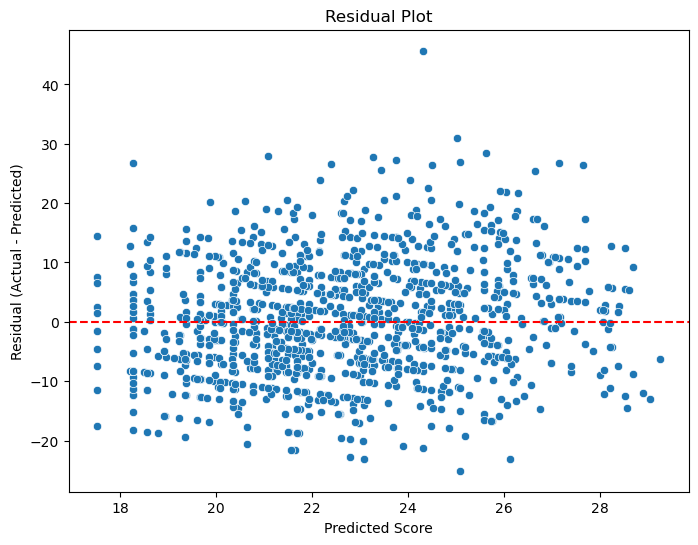

In [26]:
#calculating errors with manual tuning

residuals = y_test - y_pred  

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color="red", linestyle="--")  
plt.xlabel("Predicted Score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

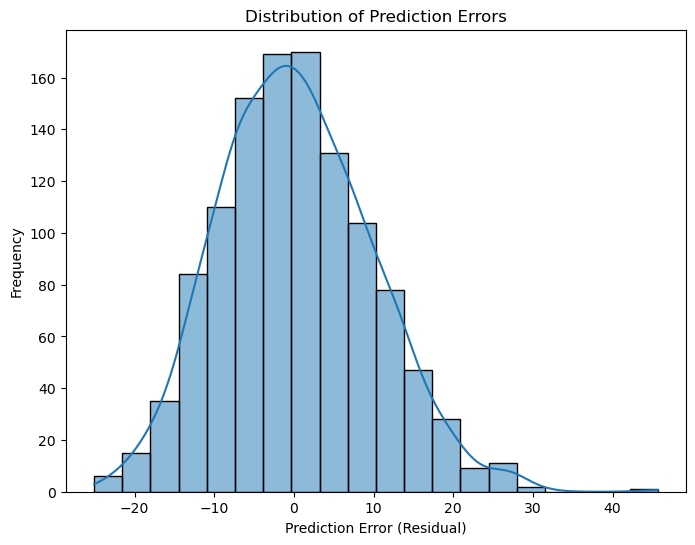

In [27]:
#bar graph showing distribution of errors using manual tuning

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [28]:
#alternative way to get optimal results -- use GridSearchCV library
'''
best results seem to be: Tuned Model - ~MAE: 7.78, RMSE: 9.72

'''

xgb_model = xgb.XGBRegressor(random_state=42)


param_grid = {
    'max_depth': [3, 5, 7],               # Controls tree complexity
    'learning_rate': [0.01, 0.1, 0.2],    # How much each tree contributes to the prediction
    'n_estimators': [50, 100, 200]        # Number of boosting rounds (trees)
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Lower MAE is better
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

In [29]:
best_params = grid_search.best_params_

# Train the model 
best_xgb = xgb.XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# predictions
y_pred_best = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_best)
rmse = mean_squared_error(y_test, y_pred_best, squared=False)

print(f"Tuned Model - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Tuned Model - MAE: 7.52, RMSE: 9.45


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


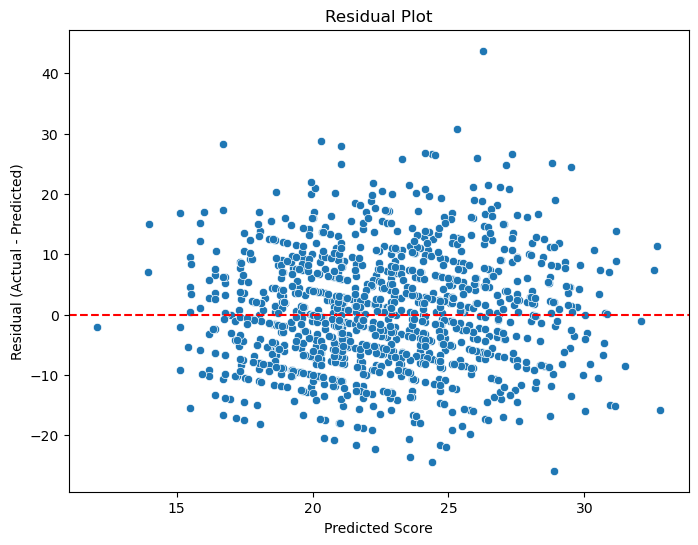

In [32]:
#calculating errors with GridSearchCV tuning

residuals_grid = y_test - y_pred_best  

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_best, y=residuals_grid)
plt.axhline(y=0, color="red", linestyle="--")  
plt.xlabel("Predicted Score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

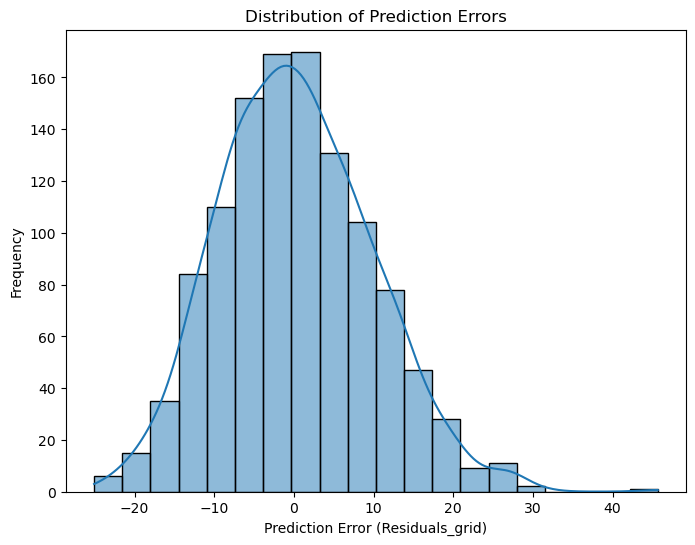

In [33]:
#bar graph showing distribution of errors using manual tuning

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Prediction Error (Residuals_grid)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [34]:
#show which defensive stat impacts score

feature_importance = best_xgb.feature_importances_

feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_df)

            Feature  Importance
0      interception    0.459222
4            qb_hit    0.197866
2  tackled_for_loss    0.154200
1     fumble_forced    0.123979
3              sack    0.064733


/var/folders/9s/w1hzjrcd3js6c63_zwcmdxt00000gn/T/ipykernel_32832/790278988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_df['Importance'], y=feature_df['Feature'], palette="viridis")


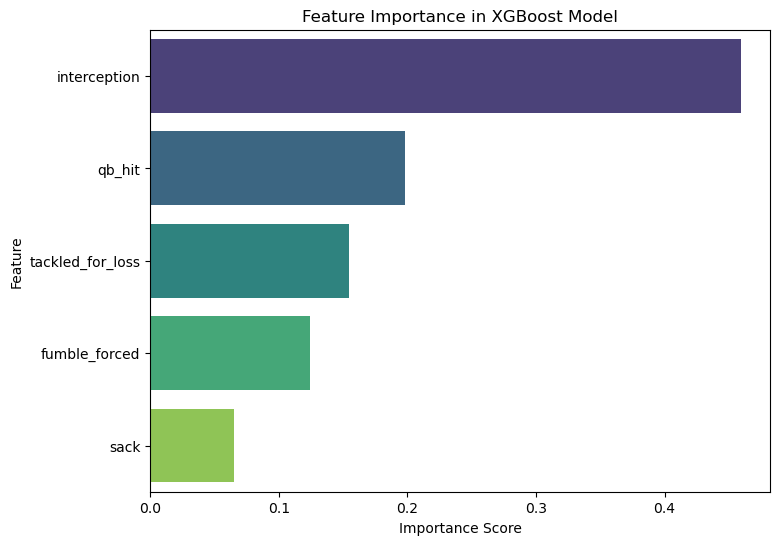

In [35]:
#plot bar chart of feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_df['Importance'], y=feature_df['Feature'], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.show()